# Getting started

This is a lightweight tutorial of how you might use Ly$\alpha$NNA for field-level inference with Ly$\alpha$ forest spectra. Here we'll look at the specific example of nSansa (Nayak et al. [2025](https://arxiv.org/abs/2510.19899)); the same procedure may be applied to Sansa (Nayak et al. [2024](https://arxiv.org/abs/2311.02167)) as well.

First import all the necessary peripheral modules:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import numpy as np
from pathlib import Path
import joblib
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size']       = 12
plt.rcParams['text.usetex']     = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

Make sure you're using TensorFlow 2.12.1. A GPU resource is not necessary for model inference, but nice to have.

In [3]:
print(
    "Using TensorFlow {:s} with {:d} GPUs".format(
        tf.__version__, len(tf.config.experimental.list_physical_devices("GPU"))
    )
)

Using TensorFlow 2.12.1 with 0 GPUs


2025-11-18 15:49:04.442103: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-11-18 15:49:04.442285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 570.172.8 does not match DSO version 570.195.3 -- cannot find working devices in this configuration


Now import `lyanna`:

In [4]:
from lyanna import architecture
from lyanna import utils
from lyanna import datautils
from lyanna import inference
from lyanna import plotting
from lyanna import assets

## Getting your data

Now get your spectra. Here we're loading mock test spectra from a "[SynTH](https://github.com/par-nay/synth)esized" transmission file:

In [5]:
R_FWHM   = 6_000
kcut_idx = 122+1  # This is the k = 0.094 s/km cutoff of Nayak et al. (2025)
N_pix    = 256

scratch_path = Path(os.environ["SCRATCH"])
testfilename = scratch_path / 'lyanna' / 'extracted_lya_abs_profiles_redshift_2.2_4096rometest_01861_S5678_cutoff_doppler.h5'
test_spectra = datautils.get_test_data_for_inference(
    testfilename,
    N_sk_to_pick = 1_000,  # How many spectra/skewers you want
    sk_start_id  = 40_000, # Index of the spectrum in the file where to start picking
    R_FWHM = R_FWHM,
    cutoff_k_idx = kcut_idx,
    N_pix_spectrum = N_pix,
)
print(f"{test_spectra.shape = }")

test_spectra.shape = (1000, 261, 1)


Note that the second dimension size is `N_pix+5`, where `N_pix = 256`. The last 5 entries are for the `lyanna` labels (similarly to a training dataset). You don't need those 5 for inference.

If available in a mock case, get the true parameter values (labels).

In [6]:
T0_test, gamma_test = test_spectra[0, N_pix:N_pix+2, 0]
T0_test_upscaled    = utils.rescale_T0(T0_test, mode = 'up')
gamma_test_upscaled = utils.rescale_gamma(gamma_test, mode = 'up')
print(f"T_0 = {T0_test_upscaled:.0f} K, gamma = {gamma_test_upscaled:.2f}")

T_0 = 10765 K, gamma = 1.57


Here we're adding some noise to the spectra artificially. If you need to do it as well, please note the range of CNR the model is trained with before proceeding.

In [7]:
sigp  = 0.01
rng   = np.random.default_rng(42)
noise = rng.normal(0.0, sigp, test_spectra[:,:N_pix].shape,) # Homoscedastic
test_spectra_noisy = np.copy(test_spectra)
test_spectra_noisy[:,:N_pix] += noise

## Getting the NN

This is how you might load the NN you want to use:

In [8]:
if True:
# with tf.device('/device:gpu:0'):
    nsansa = architecture.create_nSansa() 
# nsansa.summary()    # Optionally show the keras model architecture summary

If you want to use a GPU for model inference, comment the first line above and uncomment the second and specify your device.

For inference with Sansa or nSansa you'd need the trained model weights for the entire committee. For nSansa this amounts to $\gtrsim$3GB. Proceed with discretion.

Here we download all the assets:

In [9]:
assets_rec  = assets.get_assets(scratch_path / 'lyanna')  # Note the release tag in assets.py beforehand
assets_path = Path(assets_rec['root'])

[lyanna] Downloading nsansa_delfi_gmm.joblib: 100%|██████████| 21.8k/21.8k [00:00<00:00, 6.51MB/s]
[lyanna] Downloading nsansa_emulator.joblib: 100%|██████████| 1.88M/1.88M [00:00<00:00, 31.4MB/s]
[lyanna] Downloading nsansa_weights_0.tar.gz: 100%|██████████| 1.40G/1.40G [00:07<00:00, 183MB/s]
[lyanna] Downloading nsansa_weights_1.tar.gz: 100%|██████████| 1.40G/1.40G [00:08<00:00, 165MB/s] 
[lyanna] Downloading sansa_W_matrices.npy: 100%|██████████| 768/768 [00:00<00:00, 246kB/s]
[lyanna] Downloading sansa_weights.tar.gz: 100%|██████████| 10.4M/10.4M [00:00<00:00, 103MB/s]
[lyanna] Extracting nsansa_weights_0.tar.gz: 100%|██████████| 1100/1100 [00:45<00:00, 24.32files/s]
[lyanna] Assets ready.


In [10]:
weights_list = list(Path(assets_rec['nsansa_weights']).glob('weights_*'))
print(f"{len(weights_list)} committee members loaded.")

2200 committee members loaded.


In [11]:
emulator = joblib.load(assets_path / "nsansa_emulator.joblib")
delfi    = joblib.load(assets_path / "nsansa_delfi_gmm.joblib")

def nsansa_emulator(T0, gamma):
    alpha, beta = utils.change_basis(T0, gamma)
    return emulator([[alpha, beta, sigp]])[0]

Don't forget to define your prior function. Currently the module only supports a flat prior where the `is_in_prior` function returns `True` or `False` depending on the location of the input point in the parameter space. It's pretty straightforward to make any tweaks for more complicated priors.

In [12]:
def is_in_prior(T0, gamma): # these are downscaled
    alpha, beta = utils.change_basis(T0, gamma)
    if alpha<1.0 and alpha>-1.0 and beta<1.0 and beta>-1.0:
        return True
    else:
        return False

## Inference with Ly$\alpha$NNA

Now we're ready to do inference. First create an instance of the class `LyaNNA`:

In [13]:
lyanna_inf = inference.LyaNNA(
    nsansa, 
    weights_list, 
    is_in_prior = is_in_prior, 
    emulator = nsansa_emulator, 
    delfi = delfi
)

Run the compression with your model to get a summary vector per input spectrum:

In [14]:
test_summaries = lyanna_inf.predict(
    test_spectra_noisy[:,:N_pix], 
    noise_sigmas = sigp * np.ones(len(test_spectra_noisy)), 
    steps = 5, 
    verbose = 3,
)
test_summaries.shape

(1000, 2)

In [15]:
mean_summary = np.mean(test_summaries, axis = 0)
mean_summary.shape

(2,)

Let's compute the covariance matrix of the compressed summary vectors via stratified subsampling for likelihood-based inference.

In [16]:
test_summaries_stratified = utils.stratified_subsample_means(
    test_summaries, 
    subset_size  = 100,
    n_iterations = 1_000,
)
test_summaries.shape

(1000, 2)

In [17]:
cov_test  = np.cov(test_summaries_stratified, rowvar = False)
icov_test = np.linalg.inv(cov_test)
icov_test.shape

(2, 2)

Sometimes it's nice to look at your compressed summary vectors:

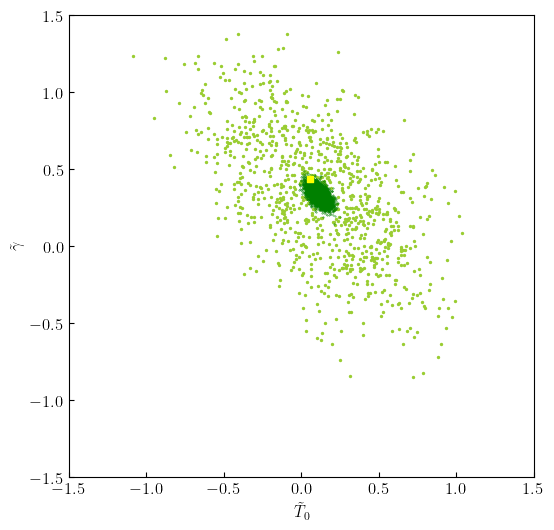

In [18]:
plt.figure(figsize = (6,6))
plt.scatter(
    test_summaries[:,0], 
    test_summaries[:,1], 
    s = 2, color = 'yellowgreen',
)
plt.scatter(
    test_summaries_stratified[:,0], 
    test_summaries_stratified[:,1], 
    s = 0.1, color = 'green',
)
plt.scatter(T0_test, gamma_test, s = 20, color = 'yellow', marker = 's')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel(r'$\tilde{T}_0$')
plt.ylabel(r'$\tilde{\gamma}$')
plt.show()

And then run all the MCMC chains you need:

In [19]:
mcmc_lkd  = lyanna_inf.infer(
    mean_summary,
    method  = 'lkd',
    noise_sigma = sigp,
    inv_cov = icov_test,
    truth   = (T0_test_upscaled, gamma_test_upscaled),
    N_walkers = 100,
    N_iterations = 5_000,
    show_progress = True,
)

100%|██████████| 5000/5000 [01:35<00:00, 52.55it/s]


In [20]:
mcmc_delfi  = lyanna_inf.infer(
    mean_summary,
    method  = 'delfi',
    noise_sigma = sigp,
    truth   = (T0_test_upscaled, gamma_test_upscaled),
    N_walkers = 100,
    N_iterations = 5_000,
    show_progress = True,
)

100%|██████████| 5000/5000 [02:13<00:00, 37.42it/s]


In [21]:
lkd_chain   = mcmc_lkd.get_chain(N_skewers_rescale = 100)
delfi_chain = mcmc_delfi.get_chain(N_skewers_rescale = 100)
lkd_chain.shape, delfi_chain.shape

((250000, 2), (250000, 2))

Plot the posterior contours:

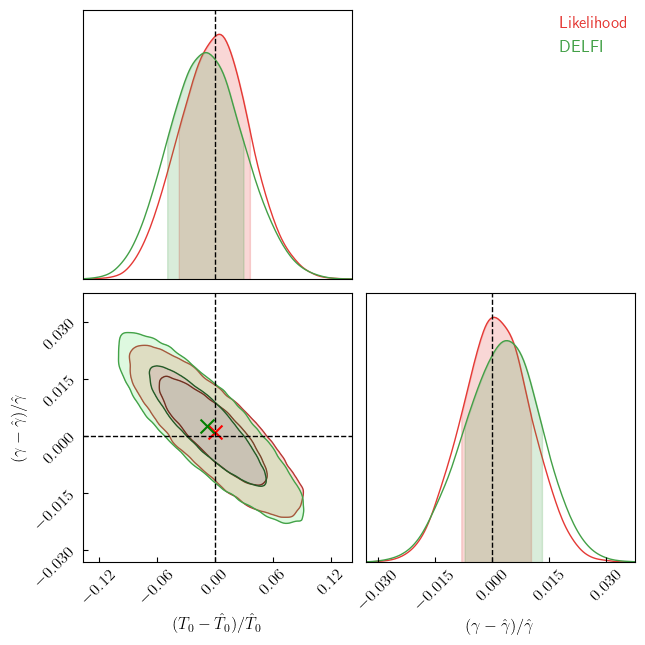

In [22]:
fig = plotting.plot_posterior_contours_from_chains(
    {
        'Likelihood': lkd_chain,
        'DELFI': delfi_chain,
    },
    font_sizes = [12,12],
)
plt.show()

Compute posterior metrics

In [23]:
lkd_metrics = lyanna_inf.compute_posterior_metrics(
    lkd_chain, 
    N_params = 2,
    truth = (0., 0.), # This is a rel chain
)
delfi_metrics = lyanna_inf.compute_posterior_metrics(
    delfi_chain, 
    N_params = 2,
    truth = (0., 0.), # This is a rel chain
)
lkd_metrics, delfi_metrics

({'fom': 5551.346042580778, 'deltachisq_r': 0.02354816142386662},
 {'fom': 5022.738260140601, 'deltachisq_r': 0.0355491702345867})